# Homework №3

This homework will be dedicated to Keyword Spotting (KWS), streaming and speedup NN.

# Data

In [1]:
import os
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2020-12-17 15:28:25--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.240, 2607:f8b0:4004:808::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   179MB/s    in 9.8s    

2020-12-17 15:28:35 (144 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


    Choose from 1 to 3 keywords to your liking, and use the rest as negative examples.
    We recommend to use sheila and/or marvin.

# Model

    In this homework assignment, you will need to implement a model for finding a keyword in a stream.

        1) https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf
            It is recommended to implement the version with CNN because it is easy and improves the model.

        2) What about streaming?
           This model works differently during training and inferance.
           During training you have some fixed input and you know that it has a keyword (or not).
           During the inferance, you read the T frames and make a prediction on them. And the next step is to read the T+1 frame,
           run the neural network just for it, and make a prediction based on it and the T-1 of the previous frames.
           This way you don't make unnecessary calculations.

           So, your model should support streaming mode.
           To demonstrate the work in streaming mode, take two random audio tracks of 10-20 seconds and glue them together
           so that your keyword will be between them. Run the model through this glued track and draw how the probability of your keyword changing over time.

        3) A good KWS is a robust KWS, so we ask you to implement as many augmentations as possible.
           (bonus) Download any noise from YouTube and add it as a background noise to the positive data. This helps a lot in real life.
           P.S. Use https://www.youtube-dl.org/

        4) (bonus) Add more attentions and orthogonality regularization. https://arxiv.org/abs/1910.04500
        
        5) (bonus) Speedup you model! Implement distillation of your model, for example,
            train the LSTM with 256 hidden size and distil it into LSTM with 128 hidden size.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!
    
    3) Good logging of experiments save your nerves and time, so we ask you to use W&B. Log loss, FA/FR rate or something else.
        Do not remove the logs until we have checked your work and given you a grade!
    
    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.
    
    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.
    
    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some audio track.

In [2]:
!pip3 install torchaudio

     |████████████████████████████████| 7.6MB 20.0MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [3]:
!pip3 install --upgrade wandb

     |████████████████████████████████| 1.8MB 16.1MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 163kB 45.1MB/s 
     |████████████████████████████████| 133kB 51.2MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=03fb3f19b0eddfc13c20d0fe29f0aa968a5b7ac33fd9d80ac567e861a53ca4de
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-1.0.1-cp36-none-any.whl size=72206 sha256=da15f5cddfd91bd524469d2e3da1265816697b5be5fc6060936ea9714372fba2
  Stored in directory: /root/.cache/pip/wheels/d8/ce/d8/31a48288b5728794feda5ac479fa324cc1cde4398c29eff064
Successfully built subprocess32 watchdog


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torchaudio
from torchaudio.transforms import FrequencyMasking, TimeMasking, MelSpectrogram
import os
import numpy as np
import random
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [5]:
def set_seed(n):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed = n
    random.seed(n)
    np.random.seed(n)

In [6]:
names = []
words = []
lbls = []
noises = []
for wv in tqdm(samples_by_target.keys()):
    if wv != '_background_noise_':
        for sample in samples_by_target[wv]:
            word = sample.split('/')[1]
            if word == 'sheila':
                lbl = 1
            else:
                lbl = 0
            names.append(sample)
            words.append(word)
            lbls.append(lbl)
    else:
        for noise in samples_by_target[wv]:
            if 'README' not in noise:
              noises.append(noise)
names = np.array(names)
lbls = np.array(lbls)
words = np.array(words)

100%|██████████| 31/31 [00:00<00:00, 693.14it/s]


In [7]:
class CommandsDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, wavs, labels, words, transform=None):
        self.root_dir = root_dir
        self.wavs=wavs
        self.labels=labels
        self.words=words
        self.transform = transform
        

    def __len__(self):
        return len(self.labels)
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        wav_file = os.path.join(self.root_dir,
                                self.wavs[idx])
        
        wav = torchaudio.load(wav_file)[0][0]
        lbl = self.labels[idx]
        word = self.words[idx]
        
        
        if self.transform:
            wav = self.transform(wav)

        sample = [wav, lbl, word]
        return sample




In [8]:
class LogMelSpectrogram(nn.Module):

    def __init__(self, sample_rate: int = 16000, n_mels: int = 40, masking=True):
        super(LogMelSpectrogram, self).__init__()
        self.transform = MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels, n_fft=1024, hop_length=256, f_min=0, f_max=8000)
        self.masking=masking
        if masking:
          self.freq_masking = FrequencyMasking(freq_mask_param=10)
          self.time_masking = TimeMasking(time_mask_param=30)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spectrogram = self.transform(waveform).squeeze()
        if self.masking:
          spectrogram = self.freq_masking(spectrogram)
          spectrogram = self.time_masking(spectrogram)

        return torch.log(spectrogram + 1e-9)


class Noiser(object):
    def __init__(self, noises_list, alpha_low=0.0001, alpha_high=0.0003, p=1.0):
        self.a_low = alpha_low
        self.a_high=alpha_high
        self.noises_list = noises_list

    def __call__(self, wav):
        noise_name = self.noises_list[np.random.randint(low=0, high=len(self.noises_list))]
        noise = torchaudio.load(noise_name)[0][0]
        l = np.random.randint(low=0, high=len(noise)-len(wav)-1)
        r = l+len(wav)
        noise = noise[l:r]
        alpha = np.random.uniform(low=0.0001, high=0.0003)
        wav = wav + wav*alpha
        wav.clamp_(-1, 1)
        return wav

def my_collate(data):
    wav_batch=[]
    lbls = []
    for sample in data:
      wav_batch.append(sample[0])
      lbls.append(sample[1])
    wav_batch=pad_sequence(wav_batch, batch_first=True)
    lbls=torch.tensor(lbls)
    return wav_batch, lbls

def my_sampler(target):
    class_sample_count = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler



In [9]:
class Attention(nn.Module):
    def __init__(self, inn, linn, n_classes):
        super(Attention, self).__init__()
        self.Wxb = nn.Linear(inn, inn)
        self.Vt = nn.Linear(inn, 1, bias=False)
        self.t = nn.Tanh()

        self.out = nn.Linear(linn, n_classes, bias=False)
        self.sftmx = nn.Softmax(dim=-1)
        self.lsftmx = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        apl_a = []
        for x_ in x:
          x_ = self.Wxb(x_)
          x_ = self.t(x_)
          x_ = self.Vt(x_)
          apl_a.append(x_)
        apl_a = torch.cat(apl_a, dim=1)
        x = x.transpose(0, 1)
        apl_a = self.sftmx(apl_a).unsqueeze(1)
        res = torch.bmm(apl_a, x).squeeze()
        res = self.lsftmx(self.out(res))
        return res



In [10]:
class AtnCRNN(nn.Module):
    def __init__(self, inn, hidden, num_layers, device, n_classes=2, nd=2):
        super(AtnCRNN, self).__init__()
        self.conv5 = nn.Conv1d(inn, inn, kernel_size=5, stride=2, dilation=1, groups=inn)
        self.conv20 = nn.Conv1d(inn, hidden, kernel_size=1, stride=8, groups=int(inn/20))

        self.rnn = nn.GRU(hidden, hidden, num_layers=num_layers, dropout=0.1, bidirectional=True)
        self.num_layers=num_layers
        self.hidden=hidden
        self.device=device
        self.attention = Attention(hidden*2, hidden*nd, n_classes)

    def forward(self, x):
        h = torch.zeros(self.num_layers*2, x.shape[0], self.hidden).to(self.device)
        x = self.conv5(x)
        x = self.conv20(x)
        x = x.permute(2, 0, 1)
        #print(x.shape)
        
        x, hidn = self.rnn(x, h)
        x = self.attention(x)
        return x

In [11]:
from sklearn.metrics import accuracy_score

def FAFR_scores(preds, targets):
    FA = sum(preds[targets == 0])/len(targets)
    FR = sum(targets[preds == 0])/len(targets)
    return FA, FR

In [12]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [13]:
set_seed(42)

#wandb.init(project="dla-homework-2")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
root_dir='/content'

#dataset = CommandsDataset(root_dir, names, lbls, words, transform=Noiser(noises_list=noises))
train_len = int(len(lbls)*0.8)

idxs = np.array(range(len(lbls)))
np.random.shuffle(idxs)

train_names = names[idxs[:train_len]]
train_lbls = lbls[idxs[:train_len]]
train_words = words[idxs[:train_len]]
train = CommandsDataset(root_dir, train_names, train_lbls, train_words, transform=Noiser(noises_list=noises))
#train, val = torch.utils.data.random_split(dataset, (train_len, val_len))

val_names = names[idxs[train_len:]]
val_lbls = lbls[idxs[train_len:]]
val_words = words[idxs[train_len:]]
val = CommandsDataset(root_dir, val_names, val_lbls, val_words, transform=Noiser(noises_list=noises))

In [15]:
train_sampler = my_sampler(train_lbls)
val_sampler   = my_sampler(val_lbls)

In [16]:
batch_size=256
n_mels=40

train_loader = DataLoader(train, batch_size=batch_size, sampler=train_sampler, collate_fn=my_collate)

val_loader = DataLoader(val, batch_size=batch_size, sampler=val_sampler, collate_fn=my_collate)

In [17]:
melspec = LogMelSpectrogram(n_mels=n_mels).to(device)
melspec_val = LogMelSpectrogram(n_mels=n_mels, masking=False).to(device)

In [ ]:
model=AtnCRNN(n_mels, 128, 2, device).to(device)
lr=0.001
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)


# Training

In [ ]:
!wandb login 775938aec8c62054ff1f1878906f5cdcc20ee0e2
import wandb
wandb.init(project="dla-hw-3")
wandb.watch(model)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: captain_doggo (use `wandb login --relogin` to force relogin)


In [ ]:
from tqdm import tqdm_notebook

epochs = 40
pbar = tqdm_notebook(total = epochs*(len(train)//batch_size))
for epoch in range(epochs):
  running_loss=0.0
  val_loss=0.0
  ctr=0
  val_ctr=0
  model.train()
  for batch in train_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    X_mel = melspec(X)

    optimizer.zero_grad()

    pred = model(X_mel)
    loss = F.nll_loss(pred, y)
    running_loss+=loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()
    ctr+=1
    pbar.update(1)
  
  model.eval()
  val_preds = []
  true = []
  for batch in val_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    X_mel = melspec_val(X)
    with torch.no_grad():
      pred = model(X_mel)
      loss = F.nll_loss(pred, y)
      val_loss+=loss.item()
    pred = (torch.argmax(pred, dim=1)).cpu()
    val_preds.extend(pred.tolist())
    true.extend(y.cpu().tolist())
    val_ctr+=1
  val_preds =np.array(val_preds)
  true = np.array(true)
  FA, FR = FAFR_scores(val_preds, true)
  acc = accuracy_score(true, val_preds)
  wandb.log({'train loss':running_loss/ctr, 'val loss':val_loss/val_ctr, 'val FA':FA, 'val FR':FR, 'val acc':acc})
  print('train loss', running_loss/ctr, 'val loss', val_loss/val_ctr, 'val FA', FA, 'val FR', FR, 'val acc', acc)


pbar.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


train loss 0.6054163586917182 val loss 0.3603630451595082 val FA 0.08953263808420239 val FR 0.04990343762070298 val acc 0.8605639242950947
train loss 0.5315543764036864 val loss 0.34648051624204595 val FA 0.1164156044804944 val FR 0.020393974507531866 val acc 0.8631904210119737
train loss 0.49767975421081034 val loss 0.2462168105092703 val FA 0.052220934723831595 val FR 0.04380069524913094 val acc 0.9039783700270375
train loss 0.4600298119883232 val loss 0.2393428610236037 val FA 0.073928157589803 val FR 0.015604480494399381 val acc 0.9104673619157976
train loss 0.435218878127084 val loss 0.18007952822189705 val FA 0.03623020471224411 val FR 0.03398995751255311 val acc 0.9297798377752028
train loss 0.4244285635466646 val loss 0.1822102627917832 val FA 0.028273464658169177 val FR 0.04325994592506759 val acc 0.9284665894167632
train loss 0.4075709159297896 val loss 0.18416715018889485 val FA 0.03885670142912322 val FR 0.026033217458478176 val acc 0.9351100811123986
train loss 0.377032042

In [ ]:
model=AtnCRNN(n_mels, 128, 4, device).to(device)
lr=0.001
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [ ]:
!wandb login 775938aec8c62054ff1f1878906f5cdcc20ee0e2
import wandb
wandb.init(project="dla-hw-3")
wandb.watch(model)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from tqdm import tqdm_notebook

epochs = 40
pbar = tqdm_notebook(total = epochs*(len(train)//batch_size))
for epoch in range(epochs):
  running_loss=0.0
  val_loss=0.0
  ctr=0
  val_ctr=0
  model.train()
  for batch in train_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    X_mel = melspec(X)

    optimizer.zero_grad()

    pred = model(X_mel)
    loss = F.nll_loss(pred, y)
    running_loss+=loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()
    ctr+=1
    pbar.update(1)
  
  model.eval()
  val_preds = []
  true = []
  for batch in val_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    X_mel = melspec_val(X)
    with torch.no_grad():
      pred = model(X_mel)
      loss = F.nll_loss(pred, y)
      val_loss+=loss.item()
    pred = (torch.argmax(pred, dim=1)).cpu()
    val_preds.extend(pred.tolist())
    true.extend(y.cpu().tolist())
    val_ctr+=1
  val_preds =np.array(val_preds)
  true = np.array(true)
  FA, FR = FAFR_scores(val_preds, true)
  acc = accuracy_score(true, val_preds)
  wandb.log({'train loss':running_loss/ctr, 'val loss':val_loss/val_ctr, 'val FA':FA, 'val FR':FR, 'val acc':acc})
  print('train loss', running_loss/ctr, 'val loss', val_loss/val_ctr, 'val FA', FA, 'val FR', FR, 'val acc', acc)


pbar.close()

# Inference
Добавим модели функцию predict для выявления ключевых слов

In [125]:
class Attention(nn.Module):
    def __init__(self, inn, linn, n_classes):
        super(Attention, self).__init__()
        self.Wxb = nn.Linear(inn, inn)
        self.Vt = nn.Linear(inn, 1, bias=False)
        self.t = nn.Tanh()

        self.out = nn.Linear(linn, n_classes, bias=False)
        self.sftmx = nn.Softmax(dim=-1)
        self.lsftmx = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        apl_a = []
        for x_ in x:
          x_ = self.Wxb(x_)
          x_ = self.t(x_)
          x_ = self.Vt(x_)
          apl_a.append(x_)
        apl_a = torch.cat(apl_a, dim=1)
        x = x.transpose(0, 1)
        apl_a = self.sftmx(apl_a).unsqueeze(1)
        res = torch.bmm(apl_a, x).squeeze()
        res = self.lsftmx(self.out(res))
        return res

    def inference_layer(self, x):
        self.eval()
        return self.Vt(self.t(self.Wxb(x)))

    def inference_attn(self, apl_a, x):
        self.eval()
        x = x.transpose(0, 1)
        apl_a = self.sftmx(apl_a).unsqueeze(1)
        res = torch.bmm(apl_a, x).squeeze()
        res = self.lsftmx(self.out(res))
        return res

class AtnCRNN(nn.Module):
    def __init__(self, inn, hidden, num_layers, device, ks=5, n_classes=2, nd=2):
        super(AtnCRNN, self).__init__()
        self.ks=ks
        self.conv5 = nn.Conv1d(inn, inn, kernel_size=ks, stride=2, dilation=1, groups=inn)
        self.conv20 = nn.Conv1d(inn, hidden, kernel_size=1, stride=8, groups=int(inn/20))

        self.rnn = nn.GRU(hidden, hidden, num_layers=num_layers, dropout=0.1, bidirectional=True)
        self.num_layers=num_layers
        self.hidden=hidden
        self.device=device
        self.attention = Attention(hidden*2, hidden*nd, n_classes)

    def forward(self, x):
        h = torch.zeros(self.num_layers*2, x.shape[0], self.hidden).to(self.device)
        x = self.conv5(x)
        x = self.conv20(x)
        x = x.permute(2, 0, 1)
        #print(x.shape)
        
        x, hidn = self.rnn(x, h)
        x = self.attention(x)
        return x
    
    def inference_crnn(self, x, h):
        self.eval()
        x = self.conv5(x)
        x = self.conv20(x)
        x = x.permute(2, 0, 1)
        x, hidn = self.rnn(x, h)
        return x, hidn
    

    def predict(self, wav, melspec, confidence=0.3):
        flag_kw = False
        mel = melspec(wav).unsqueeze(0).to(self.device)
        kw_p = []
        with torch.no_grad():
          l = 45
          r = mel.shape[2] - l+1
          hidn = torch.zeros(self.num_layers*2, mel.shape[0], self.hidden).to(self.device)
          outs, hidn = self.inference_crnn(mel[:, :, :l], hidn)
          l = l - self.ks
          xs = []
          for x in outs:
            x_ = self.attention.inference_layer(x)
            xs.append(x_)
          res_x = torch.cat(xs, dim=1)
          p = self.attention.inference_attn(res_x, outs)
          kw_p.append(np.exp(p[1]))
          i = self.ks
          while i < r:
            xs = xs[1:]
            outs = outs[1:]
            frame = mel[:, :, i+l : i+l+self.ks]
            out, hidn = self.inference_crnn(frame, hidn)
            outs = torch.cat((outs, out))

            x_ = self.attention.inference_layer(out.squeeze(0))
            xs.append(x_)
            res_x = torch.cat(xs, dim=1)

            p = self.attention.inference_attn(res_x, outs)
            kw_p.append(np.exp(p[1]))
            if np.exp(p[1]) > confidence:
              if not flag_kw:
                print('Audio includes keyword')
                flag_kw = True
            i += self.ks
        if not flag_kw:
          print('Audio does not include keyword')
        plt.plot(np.zeros(len(kw_p))+confidence, label='minimum confidence')
        plt.plot(kw_p, label = 'probabilities of keyword')
        plt.legend()
        plt.show()

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
test_wav, sr1 = torchaudio.load('/content/drive/MyDrive/DLA/hw4/audio.wav')
kw_wav, sr2 = torchaudio.load('/content/speech_commands/sheila/004ae714_nohash_0.wav')

In [22]:

resampler = torchaudio.transforms.Resample(orig_freq=sr1, new_freq=sr2)
test_wav = resampler(test_wav)

# Наш тестовый пример

In [122]:
eight, sr0 = torchaudio.load('/content/speech_commands/eight/004ae714_nohash_0.wav')
dog, sr0 = torchaudio.load('/content/speech_commands/dog/00b01445_nohash_0.wav')
eight_dog_sheila = torch.zeros(eight.shape[1]+dog.shape[1]+kw_wav.shape[1])

eight_dog_sheila[:eight.shape[1]] = eight[0]
eight_dog_sheila[eight.shape[1]:eight.shape[1]+dog.shape[1]] = dog[0]
eight_dog_sheila[-kw_wav.shape[1]:] = kw_wav[0]
display_.display(display_.Audio(eight_dog_sheila, rate = 16000))

Обучим модель на нескольких эпохах и проверим инференс

In [27]:
import matplotlib.pyplot as plt

model=AtnCRNN(n_mels, 128, 4, device).to(device)
lr=0.001
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [39]:
from tqdm import tqdm_notebook

epochs = 20
pbar = tqdm_notebook(total = epochs*(len(train)//batch_size))
for epoch in range(epochs):
  running_loss=0.0
  val_loss=0.0
  ctr=0
  val_ctr=0
  model.train()
  for batch in train_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    X_mel = melspec(X)

    optimizer.zero_grad()

    pred = model(X_mel)
    loss = F.nll_loss(pred, y)
    running_loss+=loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()
    ctr+=1
    pbar.update(1)
  
  model.eval()
  val_preds = []
  true = []
  for batch in val_loader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
    X_mel = melspec_val(X)
    with torch.no_grad():
      pred = model(X_mel)
      loss = F.nll_loss(pred, y)
      val_loss+=loss.item()
    pred = (torch.argmax(pred, dim=1)).cpu()
    val_preds.extend(pred.tolist())
    true.extend(y.cpu().tolist())
    val_ctr+=1
  val_preds =np.array(val_preds)
  true = np.array(true)
  FA, FR = FAFR_scores(val_preds, true)
  acc = accuracy_score(true, val_preds)
  print('train loss', running_loss/ctr, 'val loss', val_loss/val_ctr, 'val FA', FA, 'val FR', FR, 'val acc', acc)


pbar.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


train loss 0.3367893503510893 val loss 0.1462994248551481 val FA 0.03653920432599459 val FR 0.02325222093472383 val acc 0.9402085747392815
train loss 0.34716677419804587 val loss 0.14724484801876778 val FA 0.036848203939745076 val FR 0.02302047122441097 val acc 0.9401313248358439
train loss 0.33411177904735057 val loss 0.1434429095071905 val FA 0.03623020471224411 val FR 0.02294322132097335 val acc 0.9408265739667825
train loss 0.3358911191448202 val loss 0.14301275812527714 val FA 0.03252220934723832 val FR 0.024797219003476246 val acc 0.9426805716492854
train loss 0.34255051238489853 val loss 0.14119286163180483 val FA 0.03221320973348783 val FR 0.022479721900347624 val acc 0.9453070683661645
train loss 0.3400324817581717 val loss 0.13726741908227696 val FA 0.03182696021629973 val FR 0.020702974121282348 val acc 0.9474700656624179
train loss 0.3281270854285198 val loss 0.13585703615464417 val FA 0.03229045963692545 val FR 0.024410969486288143 val acc 0.9432985708767864
train loss 0.3

In [40]:
torch.save(model.state_dict(), '/content/drive/MyDrive/DLA/hw3/kws_e20.pt')

In [126]:

model=AtnCRNN(n_mels, 128, 4, device).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DLA/hw3/kws_e20.pt'))

<All keys matched successfully>

На записи без ключевого слова:
Audio does not include keyword


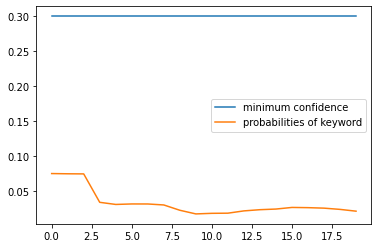

In [127]:
print('На записи без ключевого слова:')
model.predict(eight_dog_sheila[:36000], melspec_val)

Наша склеяная запись с ключевым словом
Audio includes keyword


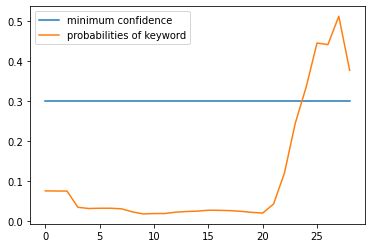

In [128]:
print('Наша склеяная запись с ключевым словом')
model.predict(eight_dog_sheila, melspec_val)